# BERT, the spam detector that uses just 10 words 
## Is 10 words enough to detect spam? (spoiler alert: it is)

The idea of this kernel is to use BERT (actually HuggingFace's [DistilBERT](https://github.com/huggingface/transformers)) to create good word embeddings for our data so we can use them in a downstream classifier. Since BERT creates very large embeddings that will not fit into memory the idea is to use only the first 10 non-stop words from every text to see if it is enough to detect spam.

[This excellent tutorial](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/) was followed to get BERT running

Installing HuggingFaces transformers package

In [4]:
!pip install transformers

In [5]:
import re
import string
import torch
import transformers
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

df = pd.read_csv("spam.csv", encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Data cleaning and feature engineering

We can discard the unnamed columns and replace "ham" with 0 and "spam" with 1

Two new features are engineered:
- `num_words` -> Indicates the number of words in the message
- `message_len` -> The length of the message

In [0]:
df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True, axis=1)

#Adding new features
df["num_words"] = df["v2"].apply(lambda s: len(re.findall(r'\w+', s))) # Count the number of words in the message
df["message_len"] = df["v2"].apply(len) # get the length of the text message

df["v1"].replace({"ham": 0, "spam":1}, inplace=True)

df.rename({"v1": "is_spam", "v2": "message"},axis=1, inplace=True)

In [0]:
import nltk

In [8]:
# !nltk.download('stopwords')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

When cleaning the sentences punctuation is removed as well as english stopwords. For memory size reasons (as well as just for the challenge of it (:) only the first 10 non-stopword tokens are used to detect spam 

In [0]:
def clean_sentence(s):
    """Given a sentence remove its punctuation and stop words"""
    
    stop_words = set(stopwords.words('english'))
    s = s.translate(str.maketrans('','',string.punctuation)) # remove punctuation
    tokens = word_tokenize(s)
    cleaned_s = [w for w in tokens if w not in stop_words] # removing stop-words
    return " ".join(cleaned_s[:10]) # using the first 10 tokens only

df["message"] = df["message"].apply(clean_sentence)

## Loading DistilBERT

We'll load the uncased base model (the smaller model). This model is easier to train in a "normal" computer and since it is uncased we do not have to worry about case sensitivity!

In [10]:
# Loading pretrained model/tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased")

### Tokenizer

Since machine learning/deep learning models only work with numbers we need to convert every word to a number. We'll use DistilBERTTokenizer for this. This will separete the words in the sentence, add special tokens ("[CLS]" and "[SEP]") and replace every word for an ID

In [11]:
tokenized = df["message"].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
tokenized

0       [101, 2175, 18414, 17583, 2391, 4689, 2800, 11...
1       [101, 7929, 2474, 2099, 16644, 15536, 2546, 10...
2       [101, 2489, 4443, 1016, 1059, 2243, 2135, 4012...
3       [101, 1057, 24654, 2360, 2220, 7570, 2099, 105...
4       [101, 20976, 1045, 2123, 2102, 2228, 3632, 214...
                              ...                        
5567    [101, 2023, 3416, 2051, 2699, 1016, 3967, 1057...
5568    [101, 2097, 1045, 1038, 2183, 9686, 24759, 516...
5569          [101, 12063, 6888, 2061, 19092, 15690, 102]
5570    [101, 1996, 3124, 7743, 2075, 1045, 6051, 2066...
5571           [101, 20996, 10258, 2049, 2995, 2171, 102]
Name: message, Length: 5572, dtype: object

Each row in tokenized is an array of numbers that represents a sentence in our dataset. Note that every sentence starts with 101, that's the ID for the "[CLS]" token

### Padding
Since some sentences are longer than others will need to padd them so they all have the same size

In [12]:
max_len = tokenized.apply(len).max() # get the length of the longest tokenized sentence

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values]) # padd the rest of the sentence with zeros if the sentence is smaller than the longest sentence
padded

array([[  101,  2175, 18414, ...,     0,     0,     0],
       [  101,  7929,  2474, ...,     0,     0,     0],
       [  101,  2489,  4443, ...,     0,     0,     0],
       ...,
       [  101, 12063,  6888, ...,     0,     0,     0],
       [  101,  1996,  3124, ...,     0,     0,     0],
       [  101, 20996, 10258, ...,     0,     0,     0]])

But now since we've added these zeros we'll have to create another matrix in which to tell BERT what should it pay attention and what should it ignore. Everything that is a zero we tell BERT to ignore it

In [13]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

Finally we can send our input data to BERT to get the classification embeddings for the messages

In [0]:
input_ids = torch.tensor(padded)  # create a torch tensor for the padded sentences
attention_mask = torch.tensor(attention_mask) # create a torch tensor for the attention matrix

with torch.no_grad():
    encoder_hidden_state = model(input_ids, attention_mask=attention_mask)

The first element in `encoder_hidden_state` is the one we want. This matrix is of shape (number_of_sentences, max_sentence_length, 768). From this matrix we are only interested in the first column of every row, which is the column with the "[CLS]" embedding, the embedding used for classification

In [0]:
X = encoder_hidden_state[0][:,0,:].numpy()
X = np.hstack((X, df[["num_words", "message_len"]].to_numpy().reshape(-1, 2))) # addind the the engineered features from the beginning
y = df["is_spam"]

Now that we have our features and labels defined we can beging the modeling part of the problem

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# EDA

First lets look at the manifold distribution of the data to see how did our embeddings fair in encoding the messages. We'll use T-SNE to reduce the dimensions in the data down to just 2 so we can plot them

In [17]:
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X_train)
X_embedded.shape

(4179, 2)

In [0]:
# creating the dataframe for plotting
def creat_plotting_data(data, labels=y_train):
    """Creates a dataframe from the given data, used for plotting"""
    
    df = pd.DataFrame(data)
    df["is_spam"] = labels.to_numpy()
    df.rename({0:"v1", 1:"v2", 768:"num_words", 769: "message_len"}, axis=1, inplace=True)
    return df

# creating the dataframes for plotting
plotting_data = creat_plotting_data(X_train)
plotting_data_embedded = creat_plotting_data(X_embedded)

## How are messages distributed in manifold space?

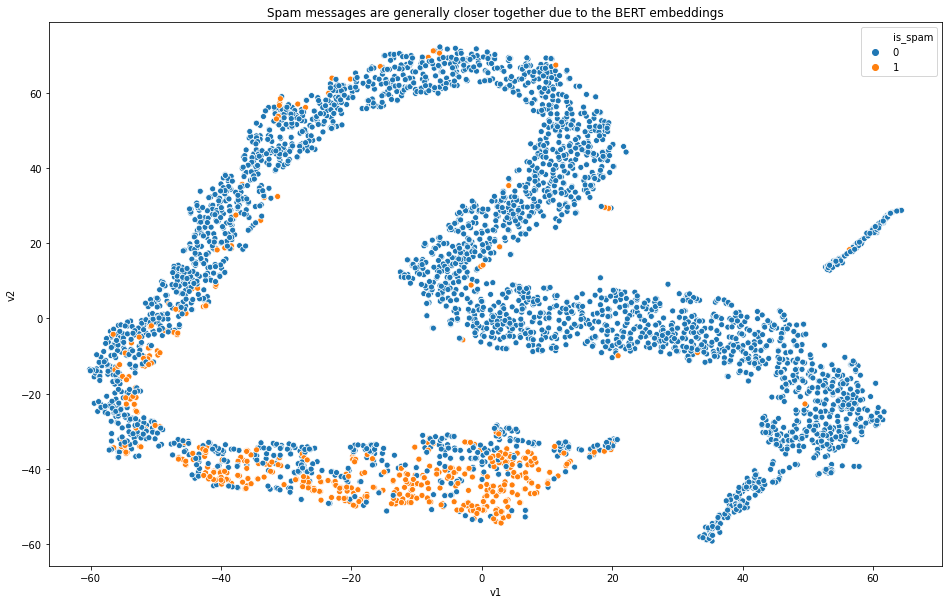

In [19]:
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x="v1", y="v2", hue="is_spam", data=plotting_data_embedded)
ax.set(title = "Spam messages are generally closer together due to the BERT embeddings")
plt.show()

Each point in this plot represents a sentence that is colorized according to it being spam or not. This shows us that the embeddings that BERT created have succesfully encoded our data in such a way that spam massages are all closer together.

Some outliers exist but it may be due to the embedding being based on only 10 tokens or just so really good spam massages.

## Do spam messages have more words than ham messages?

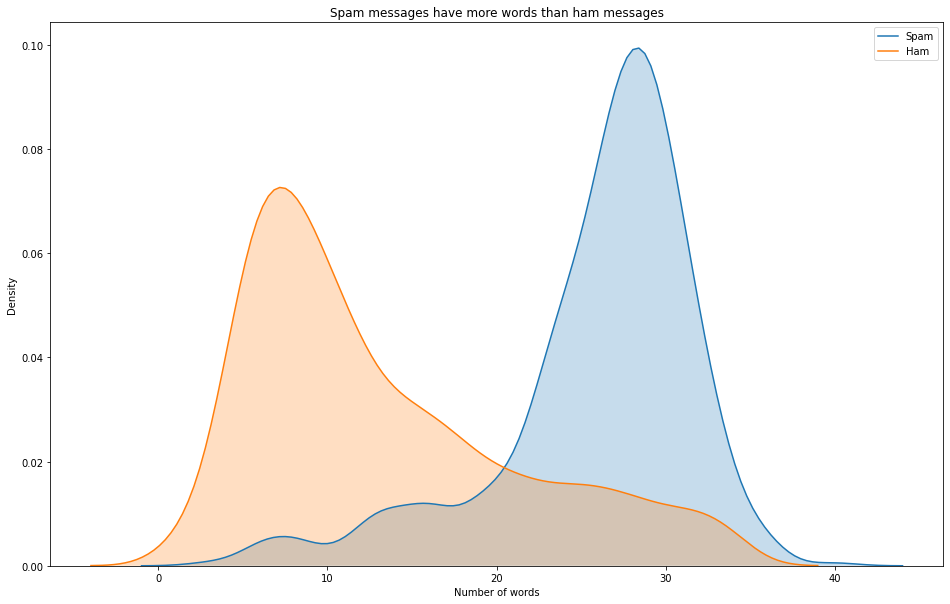

In [20]:
f,ax = plt.subplots(figsize=(16,10))
sns.kdeplot(plotting_data.loc[plotting_data.is_spam == 1, "num_words"], shade=True, label="Spam")
sns.kdeplot(plotting_data.loc[plotting_data.is_spam == 0, "num_words"], shade=True, label="Ham", clip=(0, 35)) # removing observations with message length above 35 because there is an outlier
ax.set(xlabel = "Number of words", ylabel = "Density",title = "Spam messages have more words than ham messages")
plt.show()

This plot shows us that yes Spam messages, generally, have **more** words than ham messages

## Is there any pattern in the length of the messages?

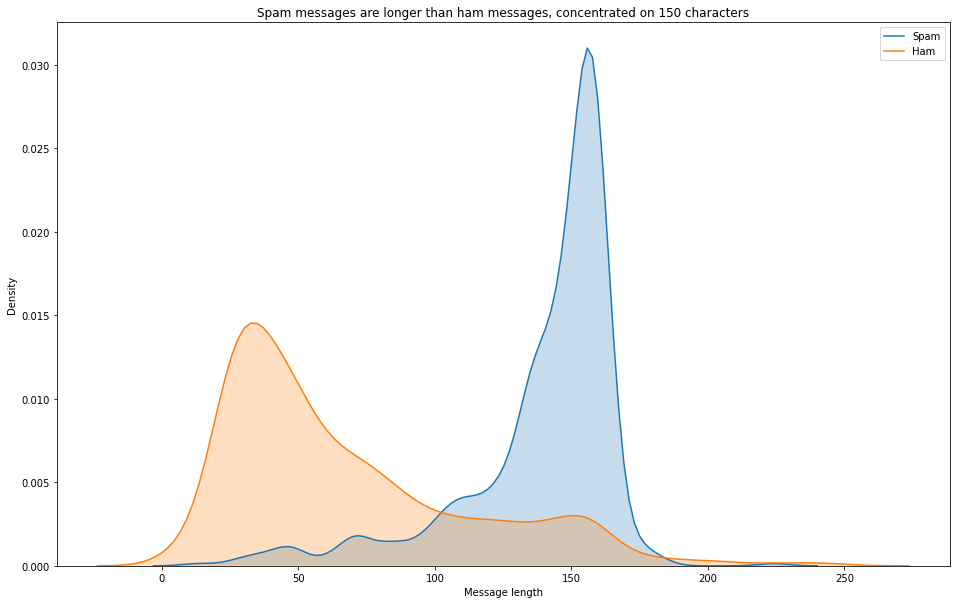

In [21]:
f,ax = plt.subplots(figsize=(16,10))
sns.kdeplot(plotting_data.loc[plotting_data.is_spam == 1, "message_len"], shade=True, label="Spam")
sns.kdeplot(plotting_data.loc[plotting_data.is_spam == 0, "message_len"], shade=True, label="Ham", clip=(0, 250)) # removing observations with message length above 250 because there is an outlier
ax.set(xlabel = "Message length", ylabel = "Density",title = "Spam messages are longer than ham messages, concentrated on 150 characters")
plt.show()

This plots shows two things:

- Spam messages are, generally, **longer** than ham messages (which is to be expected since they have more words)
- There seems to be a common value of around 150 characters for spam messages

# Baseline Random Forest

The goal of this kernel was mainly to study if 10 non-stop words would be enough to classify spam messages, not really get the greatest performance. That being said, a basic random forest is created to see how well our embeddings help out in the classification task

In [0]:
rf_classifier = RandomForestClassifier(n_estimators=1500, class_weight="balanced", n_jobs=-1, random_state=42) # Create a baseline random forest (no cross-validation, no hyperparameter tuning)
rf_classifier.fit(X_train, y_train)
preds = rf_classifier.predict(X_test)

We can see the confusion matrix for the test set

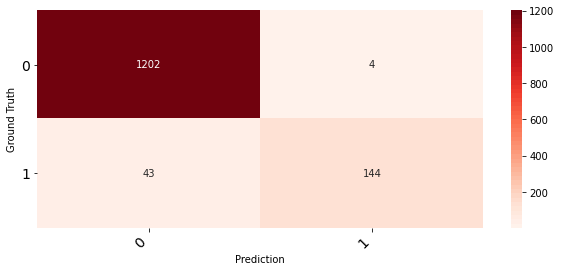

In [23]:
fig = plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(y_test, preds)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

In [24]:
print(f"""Accuray: {round(accuracy_score(y_test, preds), 5) * 100}%
ROC-AUC: {round(roc_auc_score(y_test, preds), 5) * 100}%""")
print(classification_report(y_test, preds))

Accuray: 96.626%
ROC-AUC: 88.337%
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1206
           1       0.97      0.77      0.86       187

    accuracy                           0.97      1393
   macro avg       0.97      0.88      0.92      1393
weighted avg       0.97      0.97      0.96      1393



Great! Our extremely simple random forest with no cross validation and no hyper-parameter tunning was able to achieve a 97% precision on the positive class while retrieving 76% of all positive observations. Given that we only used the 10 first non-stop words to create our embedding I'd say this is a job well done for BERT, the spam detector!

### Future Work

This kernel serves more as a tutorial to get BERT going for classification and what can you do with it. You can try embedding a larger number of words, maybe add n-grams to the messages as well and create an embedding for them. You can also tune the hyper-parameters of the random forest or use any other classification model you like!

Hope this helps :)